In [10]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [11]:
x = torch.randn(3, 64, 64)  # 더미 데이터
T = 1000
betas = torch.linspace(0.0001, 0.02, T)  # 하이퍼파라미터 생성

for t in range(T):
  beta = betas[t]
  eps = torch.randn_like(x)  # x와 같은 형상의 가우스 노이즈 생성
  x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps  # 노이즈 추가

In [12]:
# 이미지 불러오기
file_path = '/content/drive/MyDrive/DLFS5/CH09/flower.png'
image = plt.imread(file_path)
print(image.shape)  # (64, 64, 3)

(64, 64, 3)


In [13]:
# 이미지 전처리 정의
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)

torch.Size([3, 64, 64])


In [14]:
def reverse_to_img(x):
  x = x * 255                       # 각 원소(픽셀)의 값을 원래 범위로 스케일링
  x = x.clamp(0, 255)               # x의 각 원소를 0~255 범위로 제한
  x = x.to(torch.uint8)             # 데이터 타입을 torch.uint8로 변경
  to_pil = transforms.ToPILImage()  # PIL 이미지로 변환
  return to_pil(x)

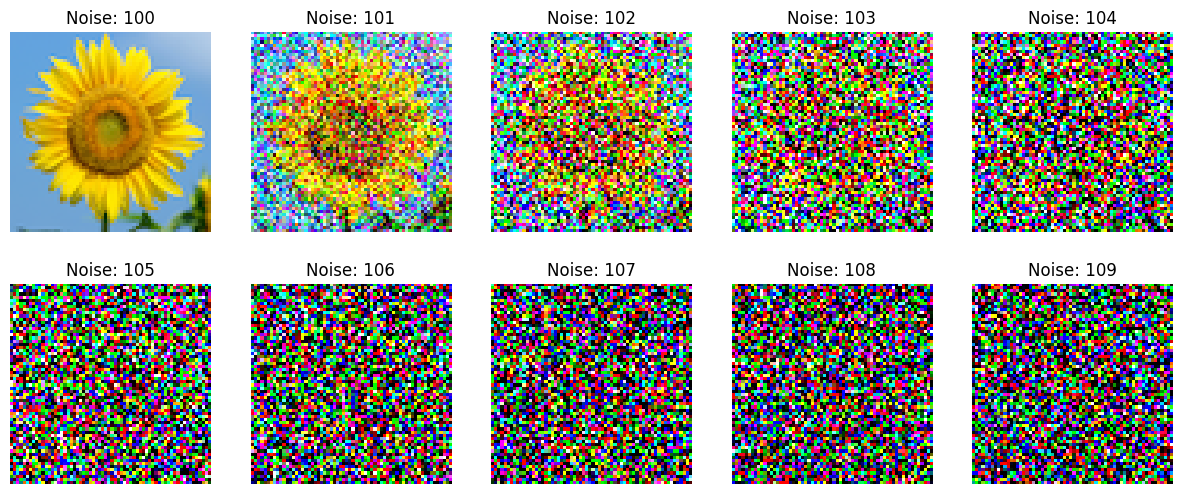

In [15]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
  if t % 100 == 0:           # 노이즈를 100번 추가할 때마다
    img = reverse_to_img(x)  # 텐서를 이미지로 복원
    imgs.append(img)         # 복원한 이미지 출력

  beta = betas[t]
  eps = torch.randn_like(x)
  x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# 10개의 이미지를 2행 5열로 표시
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f'Noise: {i + 100}')
  plt.axis('off')

plt.show()

### 9.3.3 q(x_t|x_0)으로부터 샘플링

In [17]:
# output = torch.cumprod(input, dim)
x = torch.tensor([1, 2, 3, 4])
output = torch.cumprod(x, dim=0)
print(output)

tensor([ 1,  2,  6, 24])


In [18]:
# 이미지 불러오기
file_path = '/content/drive/MyDrive/DLFS5/CH09/flower.png'
image = plt.imread(file_path)
print(image.shape)  # (64, 64, 3)

(64, 64, 3)


In [19]:
# 이미지 전처리 정의
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)

torch.Size([3, 64, 64])


In [20]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)

In [21]:
def add_noise(x_0, t, betas):
  T = len(betas)
  assert t >= 1 and t <= T  # t가 T-1 범위인지 확인

  alphas = 1 - betas
  alpha_bars =torch.cumprod(alphas, dim=0)
  t_idx = t - 1  # 시각 t에 해당하는 하이퍼파라미터 인덱스 준비
  alpha_bar = alpha_bars[t_idx]

  eps = torch.randn_like(x_0)
  x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

  return x_t  # 시각 t에서 노이지 이미지 변환

In [22]:
# 시각 100의 노이즈 이미지 생성
t = 100
x_t = add_noise(x, t, betas)

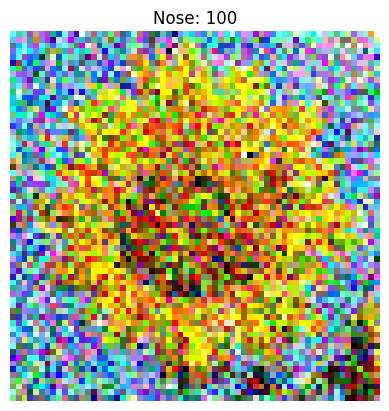

In [23]:
# 이미지 출력
img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Nose: {t}')
plt.axis('off')
plt.show()

### 9.3.4 Diffuser 클래스 구현

In [25]:
class Diffuser:
  def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
    self.num_timesteps = num_timesteps
    self.device = device
    self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
    self.alphas = 1 - betas
    self.alpha_bars = torch.cumprod(self.alphas, dim=0)

  def add_noise(self, x_0, t):
    T = self.num_timesteps
    assert (t >= 1).all() and (t <= T).all()  # 모든 원소가 1~T 범위인지 확인
    t_idx = t - 1

    alpha_bar = self.alpha_bars[t_idx]
    N = alpha_bar.size(0)
    alpha_bar = alpha_bar.view(N, 1, 1, 1)  # alpha_bar의 형상 변환

    noise = torch.randn_like(x_0, device=self.device)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
    return x_t, noise